In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Scikit-learn
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score
from sklearn.preprocessing import StandardScaler

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [3]:
# accessing date file
mass_radius_data = "mass_radius_relationship.csv"
KOI_data = "cumulativeKOIdata.csv"
TOI_data = "cumulativeTOIdata.csv"

In [4]:
mass_radius_targets = pd.read_csv(mass_radius_data)

In [5]:
TOI_targets = pd.read_csv(TOI_data)

In [6]:
KOI_targets = pd.read_csv(KOI_data)

**Paper:** IDENTIFYING EXOPLANETS WITH MACHINE
LEARNING METHODS: A PRELIMINARY STUDY
Yucheng Jin, Lanyi Yang and Chia-En Chiang April 2022

Among these features, there is a categorical target variable, koi_disposition, with three
possible values, “CONFIRMED” (labelled as 1), “CANDIDATE” (labelled as 0), and “FALSE
POSITIVE” (labelled as -1). If an exoplanet is “CONFIRMED”, we know its existence has been
confirmed, and is associated with a name recorded by kepler_name variable; if an exoplanet is
“CANDIDATE”, its existence has not been proven yet; if an exoplanet is “FALSE POSITIVE”,
it has been proven a negative observation.

In [7]:
# classification for koi_disposition
disposition_map = {
    'CONFIRMED': 1,
    'CANDIDATE': -1,
    'FALSE POSITIVE': 0 # -1 means missing
}
KOI_targets["log_koi_period"] = np.log(KOI_targets["koi_period"])
KOI_targets['koi_disposition_label'] = KOI_targets['koi_disposition'].map(disposition_map)

In [107]:
KOI_targets.head()

,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,...,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag,log_koi_period,koi_disposition_label
0,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347,2.250032,1
1,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,0,...,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347,3.996702,1
2,10811496,K00753.01,NaN,CANDIDATE,CANDIDATE,0.000,0,0,0,0,...,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436,2.990677,-1
3,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597,0.552132,0
4,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509,0.926475,1


In [8]:
# dropping the 'candidate' rows from the koi_disposition
KOI_targets_filtered = KOI_targets[KOI_targets['koi_disposition_label'] >= 0]
KOI_targets_notclassified = KOI_targets[KOI_targets['koi_disposition_label'] == -1]
x_notclassified = KOI_targets_notclassified[['koi_fpflag_nt', 'log_koi_period', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec']]
KOI_targets_filtered.head()

print(KOI_targets_filtered.shape, KOI_targets_notclassified.shape)

(7585, 51) (1979, 51)


In [9]:
print(KOI_targets_filtered['koi_fpflag_nt'].dropna().min(), KOI_targets_filtered['koi_fpflag_nt'].dropna().max())
print(KOI_targets_filtered.shape)
KOI_targets_filtered = KOI_targets_filtered[(KOI_targets_filtered['koi_fpflag_nt'] >= 0) & (KOI_targets_filtered['koi_fpflag_nt'] <= 1)]
KOI_targets_filtered = KOI_targets_filtered[(KOI_targets_filtered['koi_fpflag_ss'] >= 0) & (KOI_targets_filtered['koi_fpflag_ss'] <= 1)]
KOI_targets_filtered = KOI_targets_filtered[(KOI_targets_filtered['koi_fpflag_co'] >= 0) & (KOI_targets_filtered['koi_fpflag_co'] <= 1)]
KOI_targets_filtered = KOI_targets_filtered[(KOI_targets_filtered['koi_fpflag_ec'] >= 0) & (KOI_targets_filtered['koi_fpflag_ec'] <= 1)]
print(KOI_targets_filtered['koi_period'].dropna().min(), KOI_targets_filtered['koi_period'].dropna().max())
print(KOI_targets_filtered.shape)
# defining model independent (X) and dependent (y) values
#x_independent = KOI_targets_filtered[['koi_fpflag_nt', 'log_koi_period', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec']]
x_independent = KOI_targets_filtered[['koi_fpflag_nt', 'koi_period', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec']]
y_dependent = KOI_targets_filtered['koi_disposition_label'] # p before classification

0 465
(7585, 51)
0.241842544 1071.232624
(7584, 51)


In [10]:
# 80% for training, 20% for testing
x_train, x_test, y_train, y_test = train_test_split(x_independent, y_dependent, 
                                                    test_size = 0.2, random_state = 45)

In [11]:
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((6067, 5), (1517, 5), (6067,), (1517,))

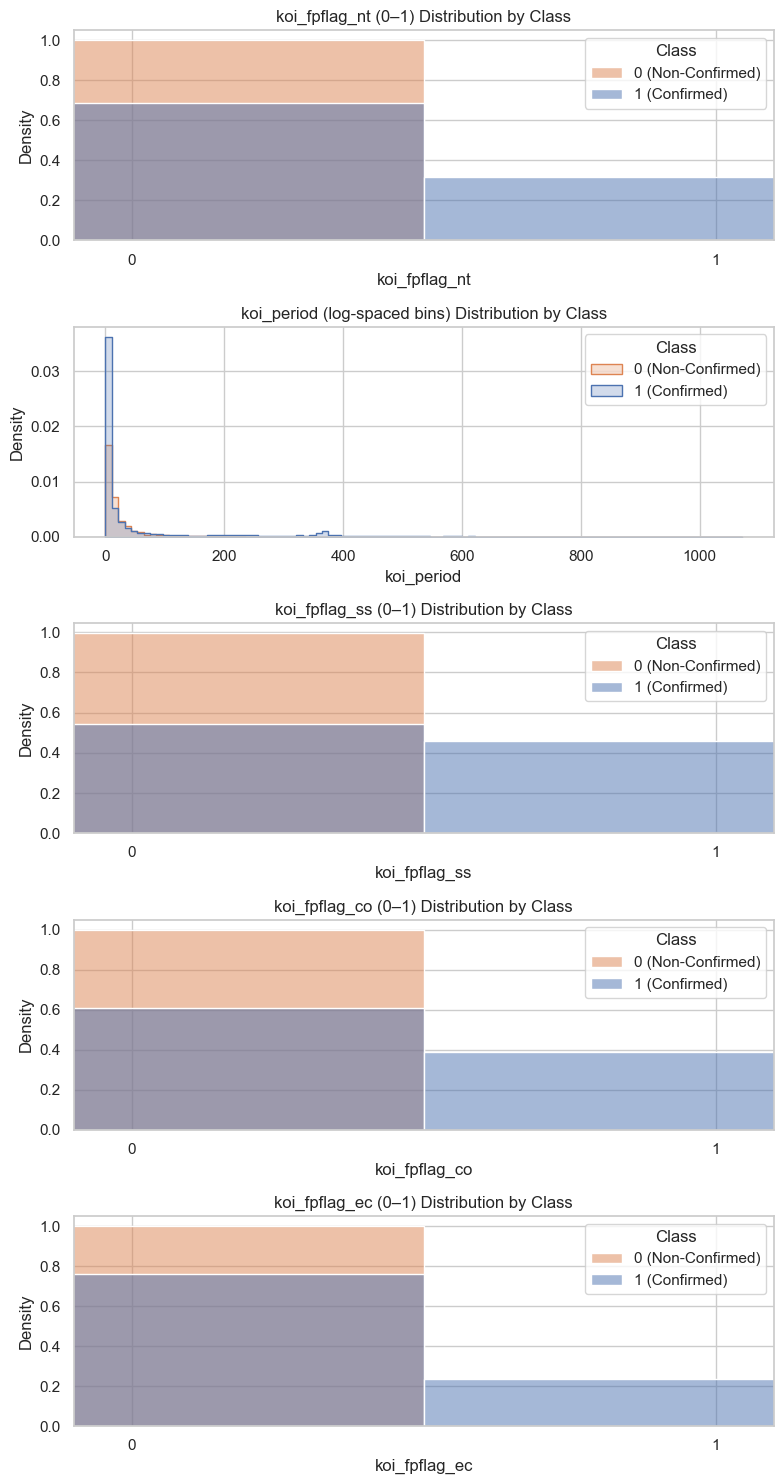

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="whitegrid")

# Combine features and target for easier plotting
data_full = x_independent.copy()
data_full['label'] = y_dependent

features = x_independent.columns
n_features = len(features)

fig, axes = plt.subplots(n_features, 1, figsize=(8, 3 * n_features))

for i, feature in enumerate(features):
    ax = axes[i]
    
    if i == 1:
        # koi_period — continuous variable → use log-spaced bins
        feature_data = data_full[feature]
        feature_data = feature_data[feature_data > 0]  # avoid log(0)
        
        # Create log-spaced bins between min and max
        #bins = np.logspace(np.log10(feature_data.min()), np.log10(feature_data.max()), 100)
        
        sns.histplot(
            data=data_full[data_full[feature] > 0],  # exclude zero/negative
            x=feature,
            hue='label',
            kde=False,
            element='step',
            stat='density',
            palette={0: 'C0', 1: 'C1'},
            ax=ax,
            bins=100
        )
        #ax.set_xscale('log')
        #ax.set_yscale('log')
        ax.set_title(f"{feature} (log-spaced bins) Distribution by Class")
        ax.set_xlabel(feature)
        ax.set_ylabel("Density")

    else:
        # Binary features (0/1) → bar-style histogram
        sns.histplot(
            data=data_full,
            x=feature,
            hue='label',
            discrete=True,
            kde=False,
            element='bars',
            stat='density',
            common_norm=False,
            palette={0: 'C0', 1: 'C1'},
            ax=ax,
            bins=[-0.5, 0.5, 1.5]
        )
        ax.set_xlim(-0.1, 1.1)
        ax.set_xticks([0, 1])
        ax.set_title(f"{feature} (0–1) Distribution by Class")
        ax.set_xlabel(feature)
        ax.set_ylabel("Density")

    ax.legend(title='Class', labels=['0 (Non-Confirmed)', '1 (Confirmed)'])

plt.tight_layout()
plt.savefig("plot_features_histogram.png")


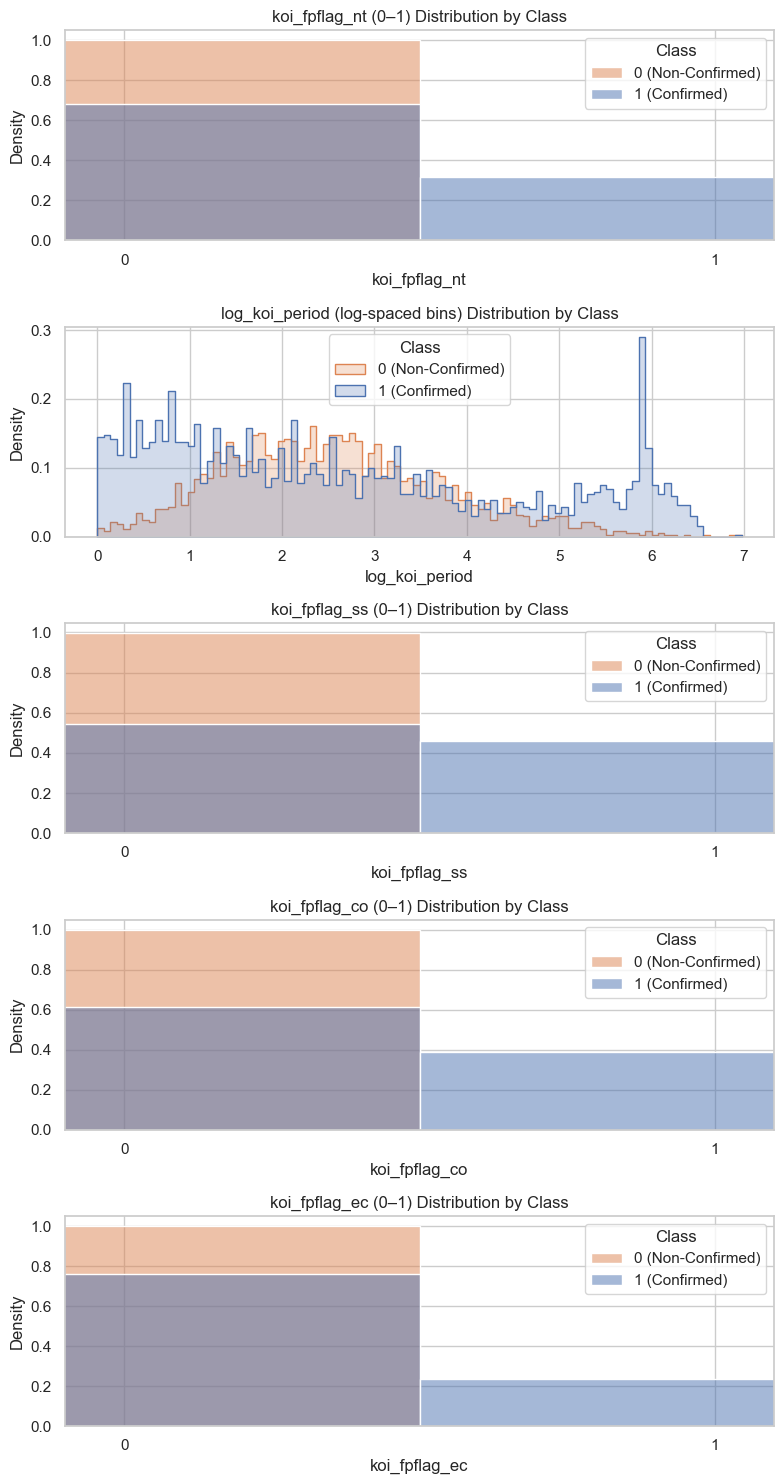

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="whitegrid")

# Combine features and target for easier plotting
features = ['koi_fpflag_nt', 'log_koi_period', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec']
data_full = pd.DataFrame(x_train, columns=features)

# Add label column
data_full['label'] = y_train

fig, axes = plt.subplots(n_features, 1, figsize=(8, 3 * n_features))

for i, feature in enumerate(features):
    ax = axes[i]
    
    if i == 1:
        # koi_period — continuous variable → use log-spaced bins
        feature_data = data_full[feature]
        feature_data = feature_data[feature_data > 0]  # avoid log(0)
        
        # Create log-spaced bins between min and max
        bins = np.logspace(np.log10(feature_data.min()), np.log10(feature_data.max()), 100)
        
        sns.histplot(
            data=data_full[data_full[feature] > 0],  # exclude zero/negative
            x=feature,
            hue='label',
            kde=False,
            element='step',
            stat='density',
            palette={0: 'C0', 1: 'C1'},
            ax=ax,
            bins=100
        )
        #ax.set_xscale('log')
        #ax.set_yscale('log')
        ax.set_title(f"{feature} (log-spaced bins) Distribution by Class")
        ax.set_xlabel(feature)
        ax.set_ylabel("Density")

    else:
        # Binary features (0/1) → bar-style histogram
        sns.histplot(
            data=data_full,
            x=feature,
            hue='label',
            discrete=True,
            kde=False,
            element='bars',
            stat='density',
            common_norm=False,
            palette={0: 'C0', 1: 'C1'},
            ax=ax,
            bins=[-0.5, 0.5, 1.5]
        )
        ax.set_xlim(-0.1, 1.1)
        ax.set_xticks([0, 1])
        ax.set_title(f"{feature} (0–1) Distribution by Class")
        ax.set_xlabel(feature)
        ax.set_ylabel("Density")

    ax.legend(title='Class', labels=['0 (Non-Confirmed)', '1 (Confirmed)'])

plt.tight_layout()
plt.show()


### Train and Evaluate Random Forest Model (classifier)

In [13]:
rfmodel = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42)
rfmodel.fit(x_train, y_train)
y_predictrf = rfmodel.predict(x_test)

print('RMSErf:', np.sqrt(metrics.mean_squared_error(y_test,y_predictrf)))

RMSErf: 0.1257803591485094


Accuracy: 0.984
Precision: 0.969
Recall (Sensitivity): 0.984
Specificity: 0.984
F1 Score: 0.977


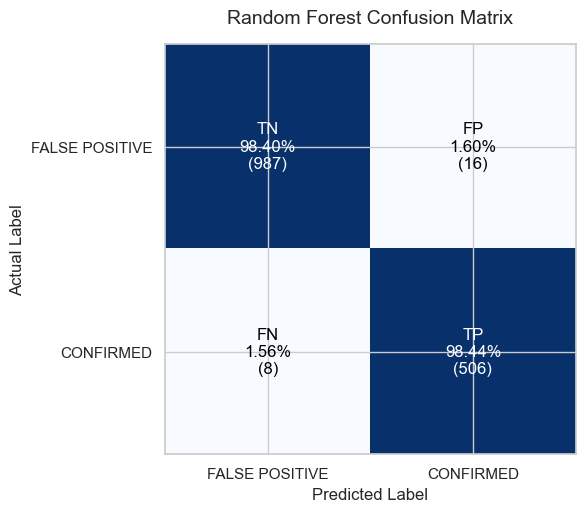

In [15]:
cm = confusion_matrix(y_test, y_predictrf, labels=[0, 1], normalize=None)
cm_percent = cm / cm.sum(axis=1, keepdims=True) * 100  # normalize per row to get percentages

labels = ['FALSE POSITIVE', 'CONFIRMED']
display = ConfusionMatrixDisplay(confusion_matrix=cm_percent, display_labels=labels)

fig, ax = plt.subplots(figsize=(6, 6))
display.plot(cmap='Blues', ax=ax, colorbar=False)

# Remove automatically added text labels
for t in ax.texts:
    t.remove()

# Define FP, FN, TP, TN labels
# Layout of confusion_matrix:
# [[TN, FP],
#  [FN, TP]]
label_texts = [['TN', 'FP'],
               ['FN', 'TP']]

# Add custom text for each cell
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        # Raw count and percent
        count = cm[i, j]
        percent = cm_percent[i, j]
        extra_label = label_texts[i][j]
        if i == j:
            ax.text(j, i,
                f"{extra_label}\n{percent:.2f}%\n({int(count)})",
                ha="center", va="center", color="white", fontsize=12)
        else:
            ax.text(j, i,
                f"{extra_label}\n{percent:.2f}%\n({int(count)})",
                ha="center", va="center", color="black", fontsize=12)

# Titles and labels
ax.set_title('Random Forest Confusion Matrix', fontsize=14, pad=15)
ax.set_xlabel("Predicted Label")
ax.set_ylabel("Actual Label")

plt.tight_layout()
plt.savefig("confusion_matrix.png")

TN, FP, FN, TP = cm.ravel()

accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall (Sensitivity): {recall:.3f}")
print(f"Specificity: {specificity:.3f}")
print(f"F1 Score: {f1:.3f}")

### Cross Validation with Random Forest

In [95]:
def modelmetrics_rmse(model, X, Y):
    cv = RepeatedKFold(n_splits=3, n_repeats=6, random_state=1)
    scores = cross_val_score(
        model, X, Y,
        scoring='neg_root_mean_squared_error',
        cv=cv,
        n_jobs=-1,
        error_score='raise'
    )
    return -scores  # returns an array of RMSE values

rmse_scores_rf = modelmetrics_rmse(rfmodel, x_independent, y_dependent)
print("RF Mean RMSE:", rmse_scores_rf.mean())
print("RF Std RMSE:", rmse_scores_rf.std())

RF Mean RMSE: 0.1316938090186744
RF Std RMSE: 0.006310932362027859


### Confusion Matrix for the Random Forest 
To get visualization of the data: 0 = FALSE POSITIVE, 1 = CONFIRMED